# Supervised methods

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import sqlite3

with sqlite3.connect('logs/logs.db') as conn:
    logs_2018 = pd.read_sql(
        'SELECT * FROM logs WHERE datetime BETWEEN "2018-01-01" AND "2019-01-01";', 
        conn, parse_dates=['datetime'], index_col='datetime'
    )
    hackers_2018 = pd.read_sql(
        'SELECT * FROM attacks WHERE start BETWEEN "2018-01-01" AND "2019-01-01";', 
        conn, parse_dates=['start', 'end']
    ).assign(
        duration=lambda x: x.end - x.start, 
        start_floor=lambda x: x.start.dt.floor('min'),
        end_ceil=lambda x: x.end.dt.ceil('min')
    )

## Get training and testing sets

In [3]:
def get_X(log, day):
    """
    Get data we can use for the X
    
    Parameters:
        - log: The logs dataframe
        - day: A day or single value we can use as a datetime index slice
    
    Returns: 
        A pandas DataFrame
    """
    return pd.get_dummies(log[day].assign(
        failures=lambda x: 1 - x.success
    ).query('failures > 0').resample('1min').agg(
        {'username':'nunique', 'failures': 'sum'}
    ).dropna().rename(
        columns={'username':'usernames_with_failures'}
    ).assign(
        day_of_week=lambda x: x.index.dayofweek, 
        hour=lambda x: x.index.hour
    ).drop(columns=['failures']), columns=['day_of_week', 'hour'])

def get_y(datetimes, hackers, resolution='1min'):
    """
    Get data we can use for the y (whether or not a hacker attempted a log in during that time).
    
    Parameters:
        - datetimes: The datetimes to check for hackers
        - hackers: The dataframe indicating when the attacks started and stopped
        - resolution: The granularity of the datetime. Default is 1 minute.
        
    Returns:
        A pandas Series of booleans.
    """
    date_ranges = hackers.apply(
        lambda x: pd.date_range(x.start_floor, x.end_ceil, freq=resolution), 
        axis=1
    )
    dates = pd.Series()
    for date_range in date_ranges:
        dates = pd.concat([dates, date_range.to_series()])
    return datetimes.isin(dates)

def get_X_y(log, day, hackers):
    """
    Get the X, y data to build a model with.
    
    Parameters:
        - log: The logs dataframe
        - day: A day or single value we can use as a datetime index slice
        - hackers: The dataframe indicating when the attacks started and stopped
        
    Returns:
        X, y tuple where X is a pandas DataFrame and y is a pandas Series
    """
    X = get_X(log, day)
    y = get_y(X.reset_index().datetime, hackers)
    return X, y

In [4]:
X_train, y_train = get_X_y(logs_2018, '2018-01', hackers_2018)
X_test, y_test = get_X_y(logs_2018, '2018-02', hackers_2018)

## Supervised anomaly detection
Now that we have our labeled data, let's use supervised learning algorithms to see if we can use this extra information to find the hackers. We will build two baseline models first:

- a dummy classifier model that will predict labels based on the stratification in the data
- a Naive Bayes model that will predict the labels using Naive Bayes

### Baselining
#### Dummy classifier
This classifier will give us a model that is equivalent to the baseline we have been drawing on our ROC curves. The results will be poor on purpose. We will never use this classifier to actually make predictions--rather, we can use it to see if the models we are building are better than random guessing strategies. 

In [5]:
from sklearn.dummy import DummyClassifier # build a baseline

dummy_model = DummyClassifier(strategy='stratified', random_state=0).fit(X_train, y_train)
dummy_preds = dummy_model.predict(X_test)

##### Evaluation Partials
Create partials for less typing

In [6]:
# create partials for less typing
from functools import partial
from sklearn.metrics import classification_report
from utils import confusion_matrix_visual, plot_roc

report = partial(classification_report, y_test)
roc = partial(plot_roc, y_test)
conf_matrix = partial(confusion_matrix_visual, y_test, class_labels=[False, True])

Text(0.5, 0.98, 'Dummy Classifier with Stratified Strategy')

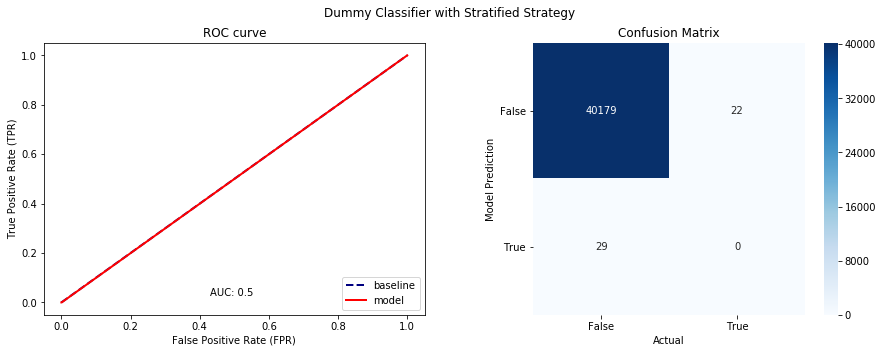

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
roc(dummy_model.predict_proba(X_test)[:,1], ax=axes[0])
conf_matrix(dummy_preds, ax=axes[1])
plt.suptitle('Dummy Classifier with Stratified Strategy')

In [8]:
print(report(dummy_preds))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     40208
        True       0.00      0.00      0.00        22

   micro avg       1.00      1.00      1.00     40230
   macro avg       0.50      0.50      0.50     40230
weighted avg       1.00      1.00      1.00     40230



#### Naive Bayes

In [9]:
from sklearn.naive_bayes import GaussianNB # build another baseline with Naive Bayes
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

nb_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('nb', GaussianNB())
]).fit(X_train, y_train)
nb_preds = nb_pipeline.predict(X_test)

c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [10]:
nb_pipeline.named_steps['nb'].class_prior_

array([9.99458801e-01, 5.41198755e-04])

c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Text(0.5, 0.98, 'Naive Bayes Classifier')

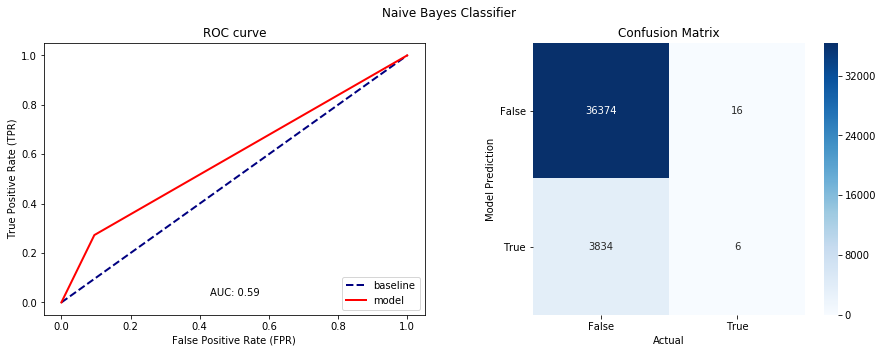

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
roc(nb_pipeline.predict_proba(X_test)[:,1], ax=axes[0])
conf_matrix(nb_preds, ax=axes[1])
plt.suptitle('Naive Bayes Classifier')

In [12]:
print(report(nb_preds))

              precision    recall  f1-score   support

       False       1.00      0.90      0.95     40208
        True       0.00      0.27      0.00        22

   micro avg       0.90      0.90      0.90     40230
   macro avg       0.50      0.59      0.48     40230
weighted avg       1.00      0.90      0.95     40230



### Logistic Regression

In [13]:
%%capture
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

lr_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('lr', LogisticRegression(solver='lbfgs', random_state=0))
])

search_space = {
    'lr__C' : [0.1, 0.5, 1, 2]
}

lr_grid = GridSearchCV(
    lr_pipeline, search_space, scoring='f1_macro', cv=5
).fit(X_train, y_train)

lr_preds = lr_grid.predict(X_test)

In [14]:
lr_grid.best_params_

{'lr__C': 0.1}

c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Text(0.5, 0.98, 'Logistic Regression Classifier')

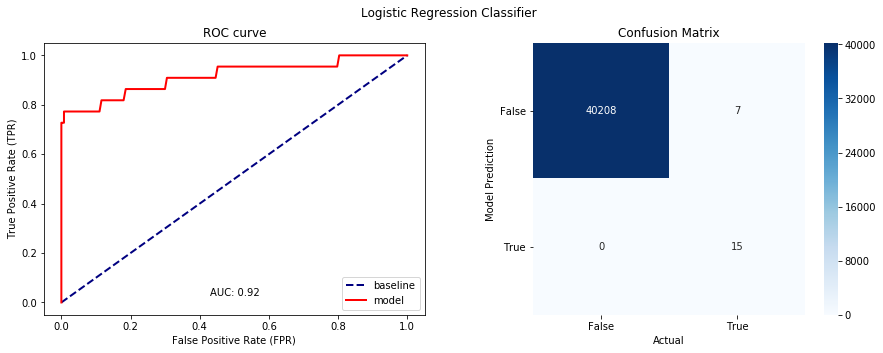

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
roc(lr_grid.predict_proba(X_test)[:,1], ax=axes[0])
conf_matrix(lr_preds, ax=axes[1])
plt.suptitle('Logistic Regression Classifier')

In [16]:
print(report(lr_preds))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     40208
        True       1.00      0.68      0.81        22

   micro avg       1.00      1.00      1.00     40230
   macro avg       1.00      0.84      0.91     40230
weighted avg       1.00      1.00      1.00     40230

